In [277]:
from collections import defaultdict, Counter
import re

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import umap as up
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.2)
np.set_printoptions(precision=3)

# Homework 8: Text as data

## Preamble

This is an ordinary homework, worth neither more nor less than usual. But it's a little different, in that it's meant to explore some of the everyday tasks of a working data scientist. To that end, you may encounter packages, visualizations, and techniques that are (a little bit) new to you. You may need to figure things out by thinking about the nature of the task and by consulting the documentation. Rest assured that we haven't asked you to do anything for which the course hasn't prepared you. There are simply fewer guardrails in this case.

Have fun!

<br><br><br><br>

# Problem 1 (10 points)

In this homework, we'll be working with a dataset from Kaggle, a popular machine learning website that hosts datasets and competitions. This dataset contains ~200,000 headlines of HuffingtonPost articles.

You can read more about the dataset here: [https://www.kaggle.com/rmisra/news-category-dataset](https://www.kaggle.com/rmisra/news-category-dataset). A copy of the data file is available on CMS alongside this homework.

To get started, load the dataset into a Pandas dataframe called `data_df`, print the total number of rows, and display five random rows. Here, and throughout the homework, be sure to print your outputs with informative context and round decimals to a reasonable number of significant figures.

In [278]:
data_df = pd.read_json(r"News_Category_Dataset_v2.json", lines=True)

print(len(f"Row count: {data_df}"))
data_df.sample(5)

2751


,category,headline,authors,link,short_description,date
12259,HEALTHY LIVING,"What Happens When You Put 500,000 People's DNA...","The Atlantic, ContributorExploring the America...",https://www.huffingtonpost.com/entry/what-happ...,Never had genetics research moved so fast.,2017-11-08
36969,POLITICS,"The Media Sucks, But It Still Should Stay In T...",Howard Fineman,https://www.huffingtonpost.com/entry/media-suc...,"In Washington, symbolism – and proximity – are...",2017-01-17
24044,POLITICS,Jeff Sessions Says 'Nothing Wrong' With The FB...,Ryan J. Reilly,https://www.huffingtonpost.com/entry/jeff-sess...,The attorney general disputed the testimony of...,2017-06-13
13600,POLITICS,Eric Holder: Harvey Weinstein Revelations Must...,Daniel Marans,https://www.huffingtonpost.com/entry/eric-hold...,"Law enforcement alone won’t solve the problem,...",2017-10-21
152762,FOOD & DRINK,Green Garlic Recipes: What It Is And How To Co...,Rebecca Orchant,https://www.huffingtonpost.com/entry/green-gar...,This late spring farmer's market arrival will ...,2013-06-26


<br><br><br><br>

# Problem 2 (20 points)

Before we can use this data for visualizations or models, we need to process the data.

(a) Create a new column called `headline_processed` that contains a processed version of the `headline` column. The text in the new column should be lowercased, all punctuation should be removed (that is, we should remove anything that isn't a letter or a number), all numbers should be replaced with a single token "NUM", and extra spaces (more than one space in a row) should be removed. Use the provided function for the punctuation removel and number token replacement.

**Confidence check:** The processed version of the headline at index position 35880 should be exactly:
```
filmmaker ava duvernay s oscar nominated documentary NUMth is a wake up call
```

(b) Create a new column called `author_processed` that contains a processed version of the `author` column. The new column should contain the full name of the first author listed in the original column (you should split the original column on commas and retain only the first element in the resulting list). Lowercase this column.

(c) Display the first five rows of the dataframe.

In [279]:
# Use this function to remove punctuation and replace numbers.

def remove_punctuation_and_replace_numbers(text):
    text = re.sub(r'[^\sA-Za-z0-9]', ' ', text)
    return re.sub('[0-9]+', 'NUM', text)

In [281]:
data_df["headline_processed"] = data_df['headline'].str.strip().str.lower().apply(remove_punctuation_and_replace_numbers)

data_df["headline_processed"][35880]

'filmmaker ava duvernay s oscar nominated documentary  NUMth   is a wake up call'

In [82]:
data_df["author_processed"] = data_df['authors'].str.split(',', n=1, expand=True)[0].str.lower()


,category,headline,authors,link,short_description,date,headline_processed,author_processed
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,there were NUM mass shootings in texas last we...,melissa jeltsen
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,will smith joins diplo and nicky jam for the N...,andy mcdonald
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,hugh grant marries for the first time at age NUM,ron dicker
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,jim carrey blasts castrato adam schiff and d...,ron dicker
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,julianna margulies uses donald trump poop bags...,ron dicker
...,...,...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28,rim ceo thorsten heins significant plans fo...,reuters
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28,maria sharapova stunned by victoria azarenka i...,
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28,giants over patriots jets over colts among m...,
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28,aldon smith arrested NUMers linebacker busted...,


In [282]:
data_df.head(5)

,category,headline,authors,link,short_description,date,headline_processed
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,there were NUM mass shootings in texas last we...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,will smith joins diplo and nicky jam for the N...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,hugh grant marries for the first time at age NUM
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,jim carrey blasts castrato adam schiff and d...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,julianna margulies uses donald trump poop bags...


<br><br><br><br>

# Problem 3 (30 points)

In this section, we'll be using an algorithm called UMAP (Uniform Manifold Approximation and Projection) to reduce the dimensions of our data so that we can visualize it in a 2-dimensional plot. UMAP is similar to PCA, t-SNE, and SVD in that we can use UMAP to reduce our data to fewer dimensions, but UMAP relies on manifold learning techniques from topological data analysis. You can read more about how UMAP works here: [https://umap-learn.readthedocs.io/en/latest/how_umap_works.html](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)

For this problem, you'll need to install the `umap-learn` package. For example, you can install this package with one of the following commands (use the one appropriate to your environment): 
- `pip3 install umap-learn`
- `conda install -c conda-forge umap-learn`

(a) Make a horizontal barplot where the **y-axis** shows each of the 10 most frequent categories in the dataset and the **x-axis** shows the number of headlines for that category.

(b) Create a new dataframe, called `sampled_df`, that is sampled from the original dataframe, `data_df`. The new dataframe should contain the first 1000 rows for each of the 10 most frequent categories. (Use your answer from 3a to determine the 10 most frequent categories.) Use `.value_counts()` to display the number of rows for each category contained in `sampled_df`.

(c) Working with `sampled_df`, use scikit-learn's `TfidfVectorizer` class with its default settings to extract vectors from the `headline_processed` column. Print the size of the resulting feature matrix (you can call `.shape` on the object containing the vectors).

(d) Using the vectors from the previous step, use UMAP's `fit_transform()` function to reduce the dimensionality of the vectors to two. Make sure to set `n_neighbors=30` and `random_state=42`. Find the new x (dimension 1) and y (dimension 2) coordinates for each vector (each headline). Plot these dimension-reduced headlines in a scatterplot, and color the points by their category. Plot the first dimension on the x-axis and the second dimension on the y-axis. **Note:** Running UMAP is slow, but should finish in a few minutes.

<AxesSubplot:ylabel='category'>

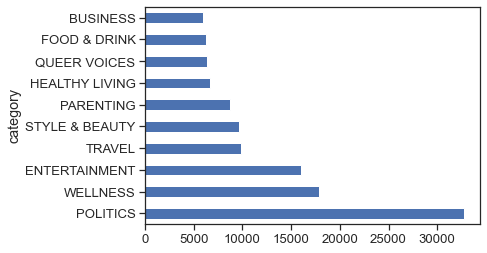

In [283]:
category_group = data_df.groupby("category")
y = category_group.category.count().sort_values(ascending = False)[0:10]
y.plot.barh()

In [310]:
top_10 = y.index.values.tolist()
sample_df = data_df.loc[data_df['category'].isin(top_10)]
sample_df = sample_df.groupby('category').head(1000).reset_index(drop = True)
sample_df.category.value_counts()


ENTERTAINMENT     1000
POLITICS          1000
QUEER VOICES      1000
BUSINESS          1000
TRAVEL            1000
HEALTHY LIVING    1000
WELLNESS          1000
PARENTING         1000
STYLE & BEAUTY    1000
FOOD & DRINK      1000
Name: category, dtype: int64

In [311]:
sample_df.category

0        ENTERTAINMENT
1        ENTERTAINMENT
2        ENTERTAINMENT
3        ENTERTAINMENT
4        ENTERTAINMENT
             ...      
9995      FOOD & DRINK
9996    STYLE & BEAUTY
9997    STYLE & BEAUTY
9998      FOOD & DRINK
9999    STYLE & BEAUTY
Name: category, Length: 10000, dtype: object

In [285]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sample_df["headline_processed"])
vectorizer.get_feature_names_out()
print(X.shape)

(10000, 13223)


In [291]:
reducer = up.UMAP(n_neighbors=30, random_state=42)
embedding = reducer.fit_transform(X)
print(f"The new x dimension is {embedding[:, 0]} and the new y dimension is {embedding[:, 1]}")

The new x dimension is [ -8.721  -9.168  -5.747 ...  -7.322 -11.336  -9.701] and the new y dimension is [3.581 4.539 3.854 ... 3.089 3.9   3.056]


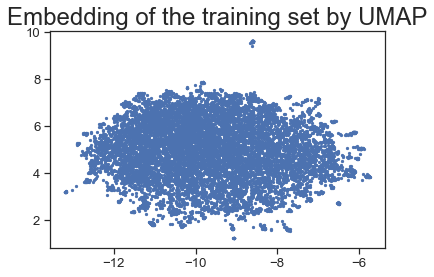

In [295]:
plt.scatter(embedding[:, 0], embedding[:, 1], s= 5, cmap='category')
plt.title('Embedding of the training set by UMAP', fontsize=24);

<br><br><br><br>

# Problem 4 (40 points)

(a) Split the data from the sampled dataframe (`sampled_df`) into training and test sets using scikit-learn's `train_test_split` function, where `test_size=0.33` and `random_state=42`. Use scikit-learn's `TfidfVectorizer` to vectorize `headline_processed` as before, but this time, be careful to only fit the vectorizer on the training data. Print the shapes and lengths of the resulting training and testing vectors and labels. **Confidence Check:** The number of training labels should match the first dimension of the training vectors, and likewise for the test labels and vectors.

(b) Train a logistic regression classifier using scikit-learn's `LogisticRegression` class and the training vectors and labels. Get the set of predictions for the test set, and print the model's performance using scikit-learn's `classification_report()` function (make sure to call `print()` on this function, so that the output displays correctly).

(c) Repeat (b) but with scikit-learn's `GaussianNB` classifier instead of `LogisticRegression`. Again, print the classification report. What do you observe in comparison to (b)?

(d) Using seaborn's `FacetGrid` class, create a series of barplots that show the number of misclassifications for each pair of categories. The FacetGrid columns should correspond to the true categories. The y-axes of the barplots should correspond to the predicted categories, while the size of the bars should correspond to the number of times that the true category was mislabeled with the predicted category. Do not include counts of true categories that were correctly predicted (these should appear as zero in the barplot). In the end, you should have a single row of ten plots, one for each of our sampled categories. (You may also use the `col_wrap` parameter to modify the output to 2 x 5 or 3 x 4 for better legibility.)

**Hint:** To make the plots easier to read, you might want to change their size using `height=4, aspect=0.7` when you instantiate `FacetGrid`. 

**Hint:** Conceptually, this is the same as creating a confusion matrix, but we're asking you to visualize that data a bit differently.

(e) Compare your output from (d) to your UMAP visualization from earlier in the assignment. Do you notice any similar patterns? Any surprises?

In [331]:
# train-test split (70%/30%)
X_test = train_test_split(sample_df, test_size= 0.33, random_state=42)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train["headline_processed"])
print(f" The labels are {vectorizer.get_feature_names_out()}")
print(f"The shape of the vectors are {X.shape}")

 The labels are ['aaron' 'abandoned' 'abandoning' ... 'zucchini' 'zuckerberg' 'zulily']
The shape of the vectors are (6700, 10822)


In [358]:
labels = vectorizer.get_feature_names_out()
testing_model = LogisticRegression().fit(X_train[X_train["headline_processed"]], labels)
testing_model.score(X.toarray(), vectorizer.get_feature_names_out())
classification_report(testing_model)

KeyError: "None of [Index(['cronut creator dominique ansel debuts  chocolate chip cookie milk shots ',\n       'traveler or tourist  why you should be both ',\n       'NUM things never to say to a special needs parent',\n       'how to stay professional in the  always on  business world',\n       'sleep your way to creativity and NUM more sure fire methods for more ideas',\n       'how to explore singapore on a budget', 'up your  gram game',\n       'armie hammer shares his mug shot from a NUM arrest for weed',\n       'exxon goes after climate ngos  warns them not to destroy communications',\n       'dads  age linked with kids  mental health problems  study ',\n       ...\n       'ramen  the ultimate broke food and how to make it at home',\n       'bayer offers to buy monsanto for  NUM billion',\n       'one drink per day may raise your breast cancer risk',\n       'trump promises to help chinese company that violated u s  sanctions on iran',\n       'tessa john connor  blogger  on how she  tames  her afro',\n       'yes  we have sloths  but no pink dolphins  animal planet on the looney front  part NUM',\n       'universal patents a wand and spells ride that sounds perfect for a new harry potter attraction',\n       'NUM travel booking secrets that will help you score cheaper flights',\n       'NUM places prince harry and meghan markle might honeymoon',\n       'how to construct the perfect green smoothie'],\n      dtype='object', length=6700)] are in the [columns]"

In [351]:
gaussian = GaussianNB()
gaussian.fit(X.toarray(), labels)

ValueError: Found input variables with inconsistent numbers of samples: [6700, 10822]